# The graph backend for SWC files

`Jaxley` has a graph backend for SWC files. This backend is based on `networkX`. This tutorial is aimed at developers that want to better understand the graph backend. For this, we will provide a full run-through of every step from an SWC file to a `jx.Cell`.

## I) Import the SWC file into `networkX`

In [13]:
from jaxley.io.graph import swc_to_graph

swc_graph = swc_to_graph("example.swc")

The `swc_graph` is a `nx.DiGraph`. The directionality indicates the direction in which the SWC file was traced. We can inspect this graph as follows:

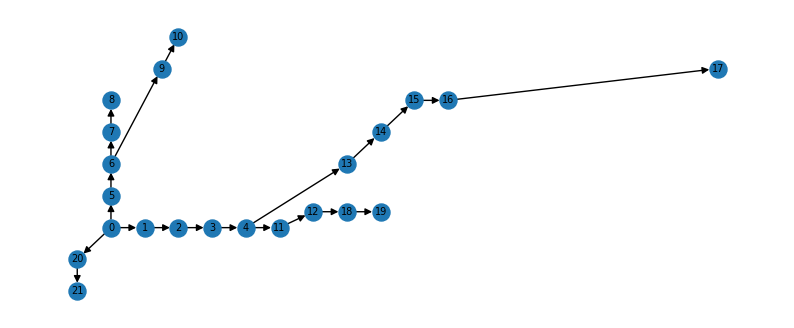

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

pos = {k: (v["x"], v["y"]) for k, v in swc_graph.nodes.items()}
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
nx.draw(swc_graph, pos=pos, with_labels=True, font_size=7, node_size=150, ax=ax)

In [15]:
print("nodes", swc_graph.nodes[0])
print("edges", swc_graph.edges[(0, 1)])

nodes {'id': 1, 'x': 0.0, 'y': 0.0, 'z': 0.0, 'r': 1.0, 'p': -1}
edges {'l': 1.0}


## II) Build the compartment graph

Next, `Jaxley` does traverses this morphology and clusters connected segments into branches. It also adds branchpoints between compartments where the branch index changes.

In [16]:
from jaxley.io.graph import build_compartment_graph

comp_graph = build_compartment_graph(swc_graph, ncomp=1)

We can again inspect this graph:

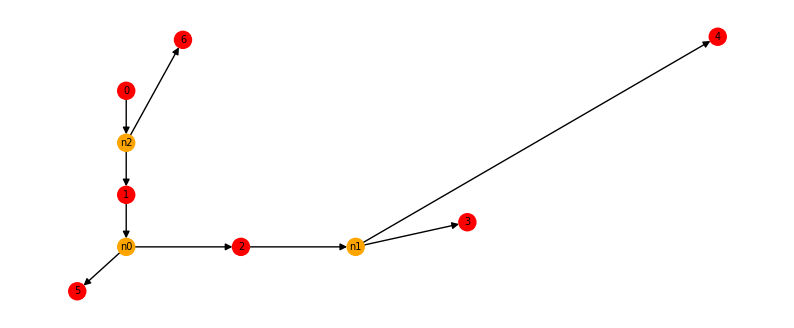

In [17]:
color_map = []
for n in comp_graph.nodes:
    if comp_graph.nodes[n].get("type") == "comp":
        color_map.append("red")
    elif comp_graph.nodes[n].get("type") == "branchpoint":
        color_map.append("orange")

pos = {k: (v["x"], v["y"]) for k, v in comp_graph.nodes.items()}
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
nx.draw(comp_graph, pos=pos, with_labels=True, font_size=7, node_size=150, ax=ax, node_color=color_map)

The red nodes are compartments, the orange nodes are branchpoints. Below, we show their attributes:

In [19]:
print(f"Compartment nodes: {comp_graph.nodes[2]}")
print(f"Branchpoint nodes: {comp_graph.nodes["n0"]}")
print(f"Edges: {comp_graph.edges[("n0", 2)]}")

Compartment nodes: {'x': 2.0, 'y': 0.0, 'z': 0.0, 'branch_index': 2, 'comp_index': 2, 'type': 'comp', 'xyzr': array([[0., 0., 0., 1.],
       [1., 0., 0., 1.],
       [2., 0., 0., 1.],
       [3., 0., 0., 1.],
       [4., 0., 0., 1.]]), 'groups': ['soma'], 'radius': 1.0, 'length': 4.0, 'cell_index': 0}
Branchpoint nodes: {'x': 0.0, 'y': 0.0, 'z': 0.0, 'p': -1, 'type': 'branchpoint', 'groups': ['soma'], 'radius': 1.0, 'length': 0.0, 'cell_index': 0}
Edges: {}


## III) Build the solve graph

The above compartment graph can be modified in any way (as long as it stays acyclic). After all modifications, `Jaxley` traverses the compartment graph again to identify the `branch_index` and the order of the `solve` (the solve is ordered because of the implicit Euler solver). You can modify the order of the traversal with the `solve_root` argument.

In [20]:
from jaxley.io.graph import from_graph

cell = from_graph(comp_graph, solve_root=0)

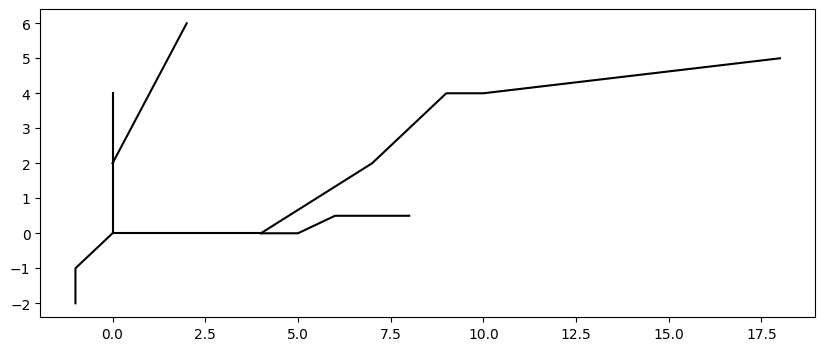

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
_ = cell.vis(ax=ax)

Internally, the following happens during `from_graph`:
- `_build_solve_graph()` traverses the `comp_graph`.
  - `_remove_branch_points()` removes all branchpoints. Instead, the directionality of the edges indicates the solve order (and in a way that every compartment has only one parent compartment after this stage)
  - `_add_meta_data()` adds the `type="cell"` and assembles the `xyzr` from all compartments into a global `graph.graph["xyzr"]`
- `_build_module()` builds a `pd.DataFrame` from the graph and uses it to create a `jx.Cell` with appropriate `cell.nodes`

As such, you can get more control by replacing `from_graph` with:

In [22]:
from jaxley.io.graph import _build_solve_graph, _build_module

solve_graph = _build_solve_graph(comp_graph, root=0)
cell = _build_module(solve_graph)